## Обучение с подкреплением

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os, jdc, shutil
from tqdm import tqdm
from multiprocessing import Process

from __future__ import print_function
from abc import ABCMeta, abstractmethod

import seaborn as sns
sns.set_style('darkgrid')

os.makedirs('results', exist_ok=True)

In [3]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [4]:
print(bcolors.OKGREEN + "Warning: No active frommets remain. Continue?" + bcolors.ENDC)
print(bcolors.WARNING + "Warning: No active frommets remain. Continue?" + bcolors.ENDC)
print(bcolors.FAIL + "Warning: No active frommets remain. Continue?" + bcolors.ENDC)

In [5]:
print(bcolors.UNDERLINE + "Warning: No active frommets remain. Continue?" + bcolors.ENDC)

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from interfaceAgent import *
from interfaceEnvironment import *
#from RLContext import *
from IPython.display import clear_output

import time

In [7]:
plt.rcParams.update({'font.size': 15})
plt.rcParams.update({'figure.figsize': [8,5]})

### Тестирование отображения карты состояний

In [8]:
from __future__ import print_function
import seaborn as sns
sns.set_style('darkgrid')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import clear_output
import time

import pygame
from pygame import *

import tkinter as tk
import tkinter.filedialog


# Объявляем переменные
WIN_WIDTH = 800  # Ширина создаваемого окна
WIN_HEIGHT = 400  # Высота
DISPLAY = (WIN_WIDTH, WIN_HEIGHT)  # Группируем ширину и высоту в одну переменную
BACKGROUND_COLOR = "#000000"
PLATFORM_WIDTH = 9
PLATFORM_HEIGHT = 9
 
        
def createField(map_dim, elements, elements_color, rewards, start_state, end_state, current_state): 
    fig, ax = plt.subplots(1, figsize=(map_dim[0], map_dim[1])) 
    rect = patches.Rectangle((0, map_dim[1]), map_dim[0], -map_dim[1], linewidth = 2, edgecolor = 'black') 
    ax.add_patch(rect)
    
    for i in range(map_dim[0]):
        for j in range(map_dim[1]):
            rect = patches.Rectangle((i,j+1), 1, -1, linewidth = 1, edgecolor = 'black', facecolor = 'white', alpha = 0.05) 
            ax.add_patch(rect)

    rect = patches.Rectangle((start_state[0], start_state[1]+1), 1, -1, linewidth = 1, edgecolor = 'black', facecolor = 'white', alpha = 0.3) 
    ax.add_patch(rect)
    for k in elements.keys():
        states = elements[k]
        for state in states:
            rect = patches.Rectangle((state[0], state[1] + 1), 1, -1, linewidth = 1, edgecolor = 'black', facecolor = elements_color[k], alpha = 0.5)
            ax.add_patch(rect)
  
    #rect = patches.Rectangle((end_state[0], end_state[1] + 1), 1, -1, linewidth = 1, edgecolor = 'black', facecolor = 'green', alpha = 0.4) 
  
    ax.add_patch(rect) 
  
    plt.xticks(np.arange(map_dim[0]+1))
    plt.yticks(np.arange(map_dim[1]+1))

    return fig,ax


def print_path_agent(a, f, current_state, map_dim, steps_agent, model, q_values):
    l = len(steps_agent)
    for idx, p in enumerate(steps_agent):
        x1, x2 = int(p[0] / 10), int(p[1] / 10)
        y1, y2 = p[0] - x1*10, p[1] - x2*10
        x = [x1 + 0.5, x2 + 0.5]
        y = [y1 + 0.5, y2 + 0.5]
        a.plot(x, y, marker = 'o', color = 'y', linewidth = 2, alpha = (idx+1)/ l)
    
    x = [current_state[0] + 0.5, current_state[0] + 0.5]
    y = [current_state[1] + 0.5, current_state[1] + 0.5]
    a.plot(x, y, marker = 'o', color = 'r', linewidth = 4)
            
    for val in model.keys():
        x = int(val/10)
        y = val - x * 10
        
        txt = f'x:{x} y:{y}\n'
        lst = list(model[val].keys())
        lst.sort()
        for k in lst:
            q = round(q_values[val][k], 6) if val in q_values.keys() else 0.0
            txt += f'{k} {model[val][k][1]}-{q}\n'
        
        a.text(x + 0.05, y - 0.05, txt, fontsize = 8, alpha = 0.7)
    


class RLContext:
    """Объединяет состояния агента и состояние наблюдаемой окружающей среды.
    Аргументы:
        env_name (string): имя модуля, в котором можно найти класс среды
        agent_name (string): имя модуля, в котором можно найти класс агента
    """

    def __init__(self, env_class, env_parmas, agent_class, show_map=True):
        pygame.init()  # Инициация PyGame, обязательная строчка
        self.screen = pygame.display.set_mode(DISPLAY)  # Создаем окошко
        pygame.display.set_caption("Field game")  # Пишем в шапку
        self.bg = Surface((WIN_WIDTH, WIN_HEIGHT))  # Создание видимой поверхности
        self.bg.fill(Color(BACKGROUND_COLOR))  # Заливаем поверхность сплошным цветом
        self.myfont = pygame.font.SysFont("monospace", 15)
        
        self.tick = 200
        
        self.timer = pygame.time.Clock()
        
        self.environment = env_class(env_parmas)
        self.agent = agent_class()
        self.idx_image = 0
        self.total_reward = None
        self.last_action = None
        self.num_steps = None
        self.num_episodes = None
        self.show_map = show_map
        self.is_terminal = True

        
    def init(self, agent_init_info={}, env_init_info={}):
        """Начальный метод, вызываемый при создания контекст"""
        self.environment.init(env_init_info)
        self.agent.init(agent_init_info)

        self.total_reward = 0.0
        self.num_steps = 0
        self.num_episodes = 0
        self.is_terminal = False

        
    def start(self, agent_start_info={}, env_start_info={}):
        """Начинается взаимодействия контекста

        Возвращается:
            tuple: (состояние, действие)
        """
        last_state, view = self.environment.start()
        self.last_action = self.agent.start(last_state, view)
        self.agent.num_episodes = self.num_episodes
        
        observation = (last_state, self.last_action)
        self.plot_map_states()
        self.plot_in_window()
        return observation
    
    def plot_in_window(self):
        self.timer.tick(self.tick)
        for e in pygame.event.get():  # Обрабатываем события
            if e.type == QUIT:
                raise SystemExit("QUIT")
            if e.type == pygame.KEYDOWN:
                if e.key == pygame.K_SPACE:
                    self.f.pause = not self.f.pause
                elif e.key == pygame.K_UP:
                    self.tick += 10
                elif e.key == pygame.K_DOWN and self.tick >= 11:
                    self.tick -= 10
                    
        self.screen.blit(self.bg, (0, 0))  # Каждую итерацию необходимо всё перерисовывать
            
        label = self.myfont.render(f" Планирование на {self.agent.planning_steps} шагов №{self.num_episodes}, шаг {self.num_steps} получено очков {self.total_reward}:", 1, (255, 255, 0))
        self.screen.blit(label, (250, 10))
            
        x = y = 0  # координаты

        for _ in range(self.environment.map_dim[0]):
            for _ in range(self.environment.map_dim[1]):
                pf = Surface((PLATFORM_WIDTH, PLATFORM_HEIGHT))
                pf.fill(Color("#ffffff"))
                self.screen.blit(pf, (x, y))
                x += PLATFORM_WIDTH
            y+=PLATFORM_HEIGHT
            x = 0
        y = 0

        pf = Surface((PLATFORM_WIDTH, PLATFORM_HEIGHT))
        pf.fill(Color("#4AA329"))
        self.screen.blit(pf, ((self.environment.start_state[0]) * PLATFORM_WIDTH, (self.environment.start_state[1]) * PLATFORM_HEIGHT))
        
        for k in self.environment.elements.keys():
            states = self.environment.elements[k]
            for state in states:
                pf = Surface((PLATFORM_WIDTH, PLATFORM_HEIGHT))
                pf.fill(Color(self.environment.elements_color[k]))
                self.screen.blit(pf, ((state[0]) * PLATFORM_WIDTH, (state[1]) * PLATFORM_HEIGHT))
        
        pf = Surface((PLATFORM_WIDTH, PLATFORM_HEIGHT))
        pf.fill(Color("#ff0000"))
        self.screen.blit(pf, ((self.environment.current_state[0]) * PLATFORM_WIDTH, (self.environment.current_state[1]) * PLATFORM_HEIGHT))
        
        pygame.display.update()  # обновление и вывод всех изменений на экран            
    
    
    def plot_map_states(self):
        """Отображение внешней среды и агента
        """
        if self.show_map:
            clear_output(wait=True) # Очищаем экран

            f,a = createField(self.environment.map_dim,
                        self.environment.elements,
                        self.environment.elements_color,
                        self.environment.rewards,
                        self.environment.start_state,
                        self.environment.end_state,
                        self.environment.current_state)

            print_path_agent(a, f, self.environment.current_state, self.environment.map_dim, self.agent.steps_agent, self.agent.model, self.agent.q_values)
            plt.title(f" Планирование на {self.agent.planning_steps} шагов №{self.num_episodes}, шаг {self.num_steps} получено очков {self.total_reward}:", fontsize = 16)
            plt.savefig(f'img_{self.idx_image}_{self.agent.planning_steps}_{self.num_episodes}_{self.num_steps}_{self.total_reward}.png', bbox_inches='tight')
            self.idx_image += 1
            plt.show()
            plt.close(f)
            plt.clf()

            
    def agent_start(self, observation, view):
        """Запускает агента.

        Аргументы:
            observation: Первое наблюдение из окружающей среды (observation - наблюдение)

        Возвращается:
            Действие, предпринятое агентом.
        """
        return self.agent.start(observation)

    
    def agent_step(self, reward, observation, view):
        """Шаг, предпринятый агентом

        Аргументы:
            reward (float): последнее вознаграждение, полученное агентом за совершение последнего действия. (reward - вознаграждение)
            observation : наблюдение за состоянием, которое агент получает из окружающей среды. (observation - наблюдение)

        Возвращается:
            Действие, предпринятое агентом.
        """
        return self.agent.next_step(reward, observation, view)

    
    def agent_end(self, reward, view):
        """Запуск при завершении работы агента

        Аргументы:
            reward (float): вознаграждение, полученное агентом при завершении контекста
        """
        self.agent.end(reward, view)

        
    def env_start(self):
        """Запуск наблюденя за внешней средой

        Возвращается:
            (float, state, Boolean): вознаграждение, наблюдение за состоянием, указатель на завершение контекста.
        """
        self.total_reward = 0.0
        self.num_steps = 1

        this_observation = self.environment.start()
        return this_observation

    
    def env_step(self, action):
        """Изменения предпринятые средой на основе действия агента

        Аргументы:
            action: Действие, предпринятое агентом.

        Возвращается:
            (float, state, Boolean): вознаграждение, наблюдение за состоянием, указатель на завершение контекста.
        """
        ro = self.environment.next_step(action)
        (this_reward, _, terminal) = ro

        self.total_reward += this_reward

        if terminal:
            self.num_episodes += 1
        else:
            self.num_steps += 1

        return ro

    
    def step(self):
        """Шаг, выполняемый контекстом, принимает изменение среды и шаг агента, а также завершение контекста.

        Возвращается:
            (float, state, action, Boolean): награда, последнее наблюдение за состоянием, последнее действие, указатель на завершение контекста.
        """

        (reward, last_state, term, view) = self.environment.next_step(self.last_action)

        self.total_reward += reward

        if term:
            self.num_episodes += 1
            self.agent.end(reward, last_state, view)
            
            roat = (reward, last_state, None, term)
        else:
            self.num_steps += 1
            self.last_action = self.agent.next_step(reward, last_state, view)
            roat = (reward, last_state, self.last_action, term)
        
        self.plot_map_states()
        self.plot_in_window()

        return roat

    
    def cleanup(self):
        """Очистка параметров контекста, среды и агента."""
        self.environment.cleanup()
        self.agent.cleanup()

        
    def agent_send_data(self, message):
        """Передача данных для агента

        Аргументы:
            message: данные переданные агенту 

        Возвращается:
            Ответное от агента
        """
        return self.agent.response(message)

    
    def env_send_data(self, message):
        """Передача данных для окружающей средой

        Аргументы:
            message: данные переданные агенту окружающей среде

        Возвращается:
            Ответное от агента внешней среды 
        """
        return self.environment.response(message)

    
    def episode(self, max_steps_this_episode):
        """Запуск эпизода контекста

        Аргументы:
            max_steps_this_episode (Int): максимальное количество шагов для выполнения эксперимента в эпизоде

        Возвращается:
            Boolean: если эпизод должен прекратиться
        """
        self.is_terminal = False

        self.num_episodes += 1
        self.num_steps = 0
        self.start()
    
        while (not self.is_terminal) and ((max_steps_this_episode == 0) or
                                     (self.num_steps < max_steps_this_episode)):
            reward, _, action, is_terminal = self.step()
            self.is_terminal = is_terminal

        return self.is_terminal

    
    def statistics(self):
        """Возвращает статистику и основные параметры RL контекста

        Возвращается:
            float: Общая награда
        """
        return self.total_reward

pygame 2.1.2 (SDL 2.0.16, Python 3.8.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


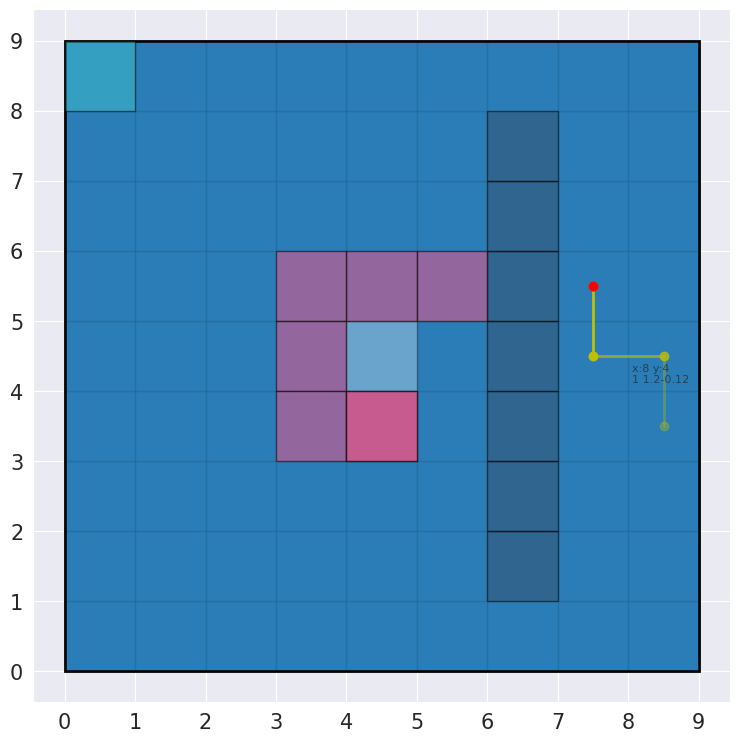

<Figure size 800x500 with 0 Axes>

In [9]:
env_parmas = {
    'map_dim':[9, 9],
    'obstacles':[[6, 1], [6, 2], [6, 3], [6, 4], [6, 5], [6, 6], [6, 7], [6, 8],
                 [5, 1], [4, 1], [3, 1], [2, 1], [1, 1],
                 [4, 3], [3, 3], [2, 3], [1, 3], [0, 3],
                 [5, 5], [4, 5], [3, 5], [2, 5], [1, 5],
                ],
    'start_state':   [8, 3],
    'end_state':     [0, 8],
    'current_state': [7, 5],
}
env_parmas = {
    'map_dim':[9, 9],
    'elements':
    {
        'wall':   [[6, 1], [6, 2], [6, 3], [6, 4], [6, 5], [6, 6], [6, 7]],
        'target': [[0, 8],],
        'pit':    [[4, 5],[5, 5],[3, 5],[3, 4],[3, 3],[4, 3]],
    },
    'rewards':{ 'wall':-0.5, 'pit':-5, 'target':5 },
    'elements_color': { 'wall':'#364F6B', 'pit':'#FC5185', 'target':'#3FC1C9' },
    'start_state': [4, 4],
    'end_state':   [0, 8],
    'current_state':[7, 5],
}

#self.steps_agent.append([int(self.past_state), state])
steps_agent = [[83, 84], [84, 74], [74,75]]
q_values = {83:[.1, .2, .3, .4], 84:[.11, .12, .13, .14]}
model = {84:{1:[83,1.2]}}
#self.q_values[int(self.past_state)][int(self.past_action)]

f, a = createField(env_parmas['map_dim'], env_parmas['elements'], env_parmas['elements_color'], env_parmas['rewards'], env_parmas['start_state'], env_parmas['end_state'], env_parmas['current_state'])
print_path_agent(a, f, 
                 env_parmas['current_state'],
                 env_parmas['map_dim'],
                 steps_agent,
                 model,
                 q_values)
#plt.title(f" Планирование на {self.agent.planning_steps} шагов №{self.num_episodes}, шаг {self.num_steps} получено очков {self.total_reward}:", fontsize = 16)

plt.show()

plt.close(f)
plt.clf()

### Класс окружающей среды

In [10]:
class MapEnvironment(InterfaceEnvironment):
    def __init__(self, env_params):
        self.map_dim = env_params['map_dim']
        #self.obstacles = env_params['obstacles']
        self.elements = env_params['elements']
        self.rewards = env_params['rewards']
        self.elements_color = env_params['elements_color']

        self.start_state = env_params['start_state']
        self.end_state = env_params['end_state']
        self.current_state = env_params['current_state']
        
        self.class_state = self.get_class_world(list(self.elements.keys()))
        
        reward = None
        observation = None
        termination = None
        self.reward_obs_term = [reward, observation, termination]
                                
                                
    def get_class_world(self, list_elements):
        class_elements = {}
        pos = 0
        for lst in [['none', 'stand_still'],list_elements]:
            for element in lst:
                class_elements[element] = pos
                pos += 1
        return class_elements
            

    def init(self, agent_info={}):
        self.reward_obs_term = [0.0, None, False]

    def start(self):
        self.current_state = self.start_state
        view = self.get_view(self.current_state)
        self.reward_obs_term[1] = self.get_observation(self.current_state)
        return self.reward_obs_term[1], view

    def get_view(self, state):
        view_mask = [0 for _ in range(4)]
        
        row = state[0]
        col = state[1]
        
        for action in range(4):
            if action == 0: # вверх
                view_mask[action] = self.get_view_class(row-1, col)
            elif action == 1: # право
                view_mask[action] = self.get_view_class(row, col+1)
            elif action == 2: # вниз
                view_mask[action] = self.get_view_class(row+1, col)
            elif action == 3: # левый
                view_mask[action] = self.get_view_class(row, col-1)
                                
        return view_mask
                                
                                
    def get_view_class(self, row, col):
        if 0 <= row and row < self.map_dim[0] and 0 <= col and col < self.map_dim[1]:                     
            for k in self.elements.keys():
                if [row, col] in self.elements[k]:
                    return self.class_state[k]
            return self.class_state['none']
        else: 
            return self.class_state['stand_still']
                            
    
    # проверьте, находится ли текущее состояние 0пределах карты
    def out_of_bounds(self, row, col):
        if row < 0 or row > self.map_dim[0]-1 or col < 0 or col > self.map_dim[1]-1:
            return True
        else:
            return False

    # проверьте, есть ли препятствие на (row, col)
    def is_hitting(self, row, col):
        if [row, col] in self.elements['wall']:
            return True, self.rewards['wall']
        else:
            return False, 0

    def get_observation(self, state):
        return state[0] * 10 + state[1]

    def next_step(self, action):
        reward = 0.0
        is_terminal = False

        row = self.current_state[0]
        col = self.current_state[1]

        # обновите current_state с помощью действия (также проверьте действительность действия)
        if action == 0: # вверх
            is_hitting, reward_hitting = self.is_hitting(row-1, col)
            if not (self.out_of_bounds(row-1, col) or is_hitting):
                self.current_state = [row-1, col]

        elif action == 1: # право
            is_hitting, reward_hitting = self.is_hitting(row, col+1)
            if not (self.out_of_bounds(row, col+1) or is_hitting):
                self.current_state = [row, col+1]

        elif action == 2: # вниз
            is_hitting, reward_hitting = self.is_hitting(row+1, col)
            if not (self.out_of_bounds(row+1, col) or is_hitting):
                self.current_state = [row+1, col]

        elif action == 3: # левый
            is_hitting, reward_hitting = self.is_hitting(row, col-1)
            if not (self.out_of_bounds(row, col-1) or is_hitting):
                self.current_state = [row, col-1]
        else:
            reward_hitting = 0
                
        reward += reward_hitting
        
        if self.current_state in self.elements['pit']:
            reward += self.rewards['pit']
            is_terminal = True

        if self.current_state == self.end_state: # завершить, если цель достигнута
            reward = self.rewards['target']
            is_terminal = True
                                
        view = self.get_view(self.current_state)

        self.reward_obs_term = [reward, self.get_observation(self.current_state), is_terminal, view]

        return self.reward_obs_term

    def cleanup(self):
        current_state = None

    def request(self, data):
        if message == "какова текущая награда?":
            return "{}".format(self.reward_obs_term[0])
        return "Я не знаю, как ответить на ваше сообщение"

### Класс агента

In [11]:
np.array([1,2,3,4])[[True, True, False, True]] 

array([1, 2, 4])

In [12]:
import random
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import SGDRegressor


class Agent(InterfaceAgent):
    def init(self, agent_info):
        try:
            self.num_states = agent_info["num_states"]
            self.num_actions = agent_info["num_actions"]
        except:
            print("Вам нужно передать как 'num_states', так и 'num_actions' в agent_info, чтобы инициализировать таблицу значений действий")
        self.gamma = agent_info.get("discount", 0.95)
        self.step_size = agent_info.get("step_size", 0.1)
        self.epsilon = agent_info.get("epsilon", 0.1) 
        self.criteria_explored = agent_info.get("criteria_explored", 0.001)
        self.num_episodes = agent_info.get("num_episodes", 0)
        self.planning_steps = agent_info.get("planning_steps", 10)
        
        
        if self.num_episodes > 10 and self.planning_steps > 10:
            self.planning_steps = 10
        if self.num_episodes > 20 and self.planning_steps > 5:
            self.planning_steps = 10
            
            
        self.min_steps = 100000

        
        self.rand_generator = np.random.RandomState(agent_info.get('random_seed', 42))
        self.planning_rand_generator = np.random.RandomState(agent_info.get('planning_random_seed', 42))
        self.is_dynamic_map_state = agent_info.get("is_dynamic_map_state", False)
        self.q_values = {}#np.zeros((self.num_states, self.num_actions))
        self.steps_agent = []
        self.actions = list(range(self.num_actions))
        self.actions_np = np.array(list(range(self.num_actions)))
        self.unexplored_map_reword = {}
        self.unexplored = set()
        
        self.coff_new_unexplored = 20
        self.coff_new_unexplored_diff_way = 0
        self.explored_map_reword_increase = .0
        self.unexplored_map_reword_increase = 20
        
        self.rand_choice = SGDClassifier()
        
        self.past_action = -1
        self.past_state = -1
        self.model = {}
        self.action_diff = {0:2, 1:3, 2:0, 3:1}
        
        self.action_view_criteria = {
        }
        self.state_view = {
        }
        
        self.query_watch_steps = set()
        self.queue_watch_steps = []
        self.len_watch_steps = 10
        
        
    def update_model(self, past_state, past_action, state, reward):
        if past_state in self.model.keys():
            self.model[past_state][past_action] = (state, reward)
            for action in self.actions:
                if action != past_action:
                    self.model[past_state][action] = (past_state, 0)
        else:
            self.model[past_state] = { past_action : (state, reward) }
            
            
    def planning_step(self):
        self.planning_step_fast_search_2()

                
    def planning_step_fast_search_2(self):
        for i in range(self.planning_steps):
            if len(self.queue_watch_steps) >= self.len_watch_steps:
                state_action = self.queue_watch_steps.pop()
                self.query_watch_steps.remove(state_action)
                
            while True:
                select_state = self.planning_rand_generator.choice( list(self.model.keys()))
                select_action = self.planning_rand_generator.choice(list(self.model[select_state].keys()))
                if (select_state, select_action) not in self.query_watch_steps:
                    self.query_watch_steps.add((select_state, select_action))
                    self.queue_watch_steps.append((select_state, select_action))
                    break
                    
                if len(self.queue_watch_steps) < self.len_watch_steps:
                    break
            
            m_next_state, m_reward = self.model[select_state][select_action]

            select_view_criteria = [self.action_view_criteria[idx] for idx in self.state_view[select_state]][select_action]

            if int(select_state) not in self.unexplored_map_reword.keys():
                self.unexplored_map_reword[int(select_state)] = np.ones((self.num_actions)) * self.coff_new_unexplored
                
            #if len(self.steps_agent) > 3:
            m_reward += self.criteria_explored * np.sqrt(self.unexplored_map_reword[select_state][select_action]) * (len(self.steps_agent)**2/100 if len(self.steps_agent) <= 10 else 1)

            if m_next_state not in self.q_values.keys():
                self.q_values[m_next_state] = np.zeros(self.num_actions)
                for pos_action in range(len(self.q_values[m_next_state])): 
                    self.unexplored.add((m_next_state, pos_action))
                    
            if select_state not in self.q_values.keys():
                self.q_values[select_state] = np.zeros(self.num_actions)
                for pos_action in range(len(self.q_values[select_state])): 
                    self.unexplored.add((select_state, pos_action))
             
            q_max = 0 if select_state == -1 else self.q_values[m_next_state][self.argmax(self.q_values[m_next_state])] 
            #q_max = 0 if select_state == -1 else (self.q_values[m_next_state][self.argmax(self.q_values[m_next_state])] if m_next_state not in self.state_view.keys() else self.q_values[m_next_state][self.argmax(self.q_values[m_next_state])]) if m_next_state == -1 else (self.q_values[m_next_state][self.argmax(self.q_values[m_next_state])] if m_next_state not in self.state_view.keys() else self.q_values[m_next_state][self.argmax(self.q_values[m_next_state])]) * [self.action_view_criteria[idx] for idx in self.state_view[m_next_state]][self.argmax(self.q_values[m_next_state])]
            self.q_values[select_state][select_action] += self.step_size * ((m_reward + self.gamma * q_max - self.q_values[select_state][select_action]))
            
                
    def argmax(self, q_values):
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            try:
                if q_values[i] > top:
                    top = q_values[i]
                    ties = []
                if q_values[i] == top:
                    ties.append(i)
            except Exception as e:
                print(e)

        return self.rand_generator.choice(ties)

    
    def choose_action_egreedy_(self, state):
        if state not in self.q_values.keys():
            self.q_values[state] = np.zeros((self.num_actions))
            for pos_action in range(len(self.q_values[state])): 
                self.unexplored.add((state, pos_action))
        
        unexplored_actions = [e for e in self.unexplored if e[0] == state]
        if len(unexplored_actions) and random.random() > 0.5:
            action = random.choice(unexplored_actions)[1]
            
        elif self.rand_generator.rand() < self.epsilon:
            p = self.q_values[state] + 1e-16 + np.abs(np.min(self.q_values[state]))
            p /= np.sum(p)
            p = np.abs(p - 1)
            p /= np.sum(p)
            action = np.random.choice(self.actions, p=p)
            
        else:
            values = self.q_values[state]
            unique = np.unique(values)
            if len(unique) == 1:
                action = np.random.choice(self.actions)
            else:
                action = self.argmax(values)

        return action
    
    
    def choose_action_egreedy(self, state):
        if state not in self.q_values.keys():
            self.q_values[state] = np.zeros((self.num_actions))
            for pos_action in range(len(self.q_values[state])): 
                self.unexplored.add((state, pos_action))
        
        criteria = []
        t1 = []
        for idx in self.state_view[state]:
            if idx not in self.action_view_criteria.keys():
                self.action_view_criteria[idx] = 1
            t1.append((idx,self.action_view_criteria[idx]))
            criteria.append(self.action_view_criteria[idx] >= 0.5)
        criteria = np.array(criteria)
        
        unexplored_actions = []
        remove_unexplored_action = []
        for e in self.unexplored:
            if e[0] == state:
                if criteria[e[1]]:
                    unexplored_actions.append(e[1])
                else:
                    remove_unexplored_action.append(e)
        
        for e in remove_unexplored_action:            
            self.unexplored.remove(e)
            
        if len(unexplored_actions) and random.random() > 0.3:
            action = random.choice(unexplored_actions)       
        elif self.rand_generator.rand() < self.epsilon:
            p = self.q_values[state]+1e-16+np.abs(np.min(self.q_values[state]))
            p = p[criteria]
            p /= np.sum(p)
            p = np.abs(p - 1)
            s = np.sum(p)
            if s != 0:
                p /= s
            n = self.actions_np[criteria]
            if len(n) == 0:
                print(n)
            action = np.random.choice(n, p=p) if len(p) > 1 else n[0]
        else:
            values = self.q_values[state]
            unique = np.unique(values)
            if len(unique) == 1:
                action = np.random.choice(self.actions)
            else:
                action = self.argmax(values*criteria)
        return action
    
    
    def start(self, state, views):
        self.past_state = state
        if state not in self.q_values.keys():
            self.q_values[state] = np.zeros((self.num_actions))
            for pos_action in range(len(self.q_values[state])): 
                self.unexplored.add((state, pos_action))
        self.state_view[state] = views
        self.past_action = self.choose_action_egreedy(state)
        self.steps_agent.append([state,state])
        return self.past_action
    
    
    def update_unexplored_map_reword(self):
        if len(self.unexplored) != 0 or self.is_dynamic_map_state:
            if len(self.steps_agent) % 2 == 0:
                for key in self.unexplored_map_reword.keys():
                    self.unexplored_map_reword[key] += random.random() * self.explored_map_reword_increase
                for (state, action) in self.unexplored:
                    if int(state) not in self.unexplored_map_reword.keys():
                        self.unexplored_map_reword[int(state)] = np.ones((self.num_actions)) * self.coff_new_unexplored
                        self.unexplored_map_reword[state][self.action_diff[action]] = self.coff_new_unexplored_diff_way
                    self.unexplored_map_reword[state][action] += self.unexplored_map_reword_increase
    
    
    def next_step(self, reward, state, views):
        if (self.past_state, self.past_action) in self.unexplored:
            self.unexplored.remove((self.past_state, self.past_action))
        self.update_unexplored_map_reword()
            
        if int(self.past_state) not in self.unexplored_map_reword.keys():
            self.unexplored_map_reword[int(self.past_state)] = np.ones((self.num_actions)) * self.coff_new_unexplored
            self.unexplored_map_reword[self.past_state][self.action_diff[self.past_action]] = self.coff_new_unexplored_diff_way
        for view in views:
            if view not in self.action_view_criteria.keys():
                self.action_view_criteria[view] = 1.0
        self.state_view[state] = views
        view_criteria =[self.action_view_criteria[idx] for idx in self.state_view[int(state)]]
        if state not in self.q_values.keys():
            self.q_values[state] = (np.ones((self.num_actions)) * np.array([view_criteria]))[0]
            self.q_values[state] /= np.sum(self.q_values[state])
            for pos_action in range(len(self.q_values[state])): 
                self.unexplored.add((state, pos_action))
            
        self.unexplored_map_reword[int(self.past_state)][(self.past_action)] = 0

                
        
        while True:
            max_action = self.choose_action_egreedy(state)
            if (state, max_action) != (self.past_state, self.past_action):
                break    
        
        if int(self.past_state) not in self.unexplored_map_reword.keys():
                self.unexplored_map_reword[int(self.past_state)] = np.ones((self.num_actions)) * self.coff_new_unexplored
        if int(state) not in self.unexplored_map_reword.keys():
                self.unexplored_map_reword[state] = np.ones((self.num_actions)) * self.coff_new_unexplored
                
        #if len(self.steps_agent) > 3:
        reward += self.criteria_explored * np.sqrt(self.unexplored_map_reword[self.past_state][self.past_action]) * (len(self.steps_agent)**2/100 if len(self.steps_agent) <= 10 else 1)

        
        #past_view_criteria = 1/[self.action_view_criteria[idx] for idx in self.state_view[int(self.past_state)]][int(self.past_action)]
        #max_view_criteria = view_criteria[int(max_action)]
        
        self.q_values[int(self.past_state)][int(self.past_action)] += self.step_size * ((reward + self.gamma * self.q_values[int(state)][int(max_action)]) - self.q_values[int(self.past_state)][int(self.past_action)])
        #self.q_values[int(self.past_state)][int(self.past_action)] += self.step_size * ((reward + self.gamma * self.q_values[int(state)][int(max_action)]) * max_view_criteria - self.q_values[int(self.past_state)][int(self.past_action)] * past_view_criteria)
        self.update_model(int(self.past_state), int(self.past_action), state, reward)
        #if len(self.steps_agent) % 2 != 0:
        self.planning_step()
        self.steps_agent.append([int(self.past_state), int(state)])
        self.past_state = int(state)
        self.past_action = int(max_action)   
        if (state, max_action) in self.unexplored:
            self.unexplored.remove((state, max_action))
        if int(state) not in self.unexplored_map_reword.keys():
            self.unexplored_map_reword[state] = np.ones((self.num_actions)) * self.coff_new_unexplored
            self.unexplored_map_reword[state][self.action_diff[max_action]] = self.coff_new_unexplored_diff_way
        self.unexplored_map_reword[state][max_action] = 0
        return self.past_action

    
    def end(self, reward, state, views):    
        for view in views:
            if view not in set(self.action_view_criteria.keys()):
                self.action_view_criteria[view] = 1.0
        self.state_view[state] = views
        
        if reward < 0:
            view_criteria = self.state_view[int(self.past_state)][int(self.past_action)]
            if view_criteria == 0:
                print()
            self.action_view_criteria[view_criteria] *= 0.9
            
        #past_view_criteria = [self.action_view_criteria[idx] for idx in self.state_view[int(self.past_state)]][int(self.past_action)]
        self.q_values[int(self.past_state)][int(self.past_action)] += self.step_size * ((reward - self.q_values[int(self.past_state)][int(self.past_action)]))
        
        self.update_unexplored_map_reword()
            
        if int(self.past_state) not in self.unexplored_map_reword.keys():
            self.unexplored_map_reword[int(self.past_state)] = np.ones((self.num_actions)) * self.coff_new_unexplored
            #self.unexplored_map_reword[self.past_state][self.action_diff[self.past_state]] = 0
            
        self.unexplored_map_reword[self.past_state][self.past_action] = 0
        
        self.update_model(int(self.past_state), int(self.past_action), -1, reward)
        #if len(self.steps_agent) % 2 != 0:
        self.planning_step()
        
        
    def cleanup(self):
        pass

    
    def request(self, data):
        pass

### Отображение результатов

In [13]:
def run_experiment(env, agent, env_parmas, env_parameters, agent_parameters, exp_parameters, show_map=True):
    num_runs = exp_parameters['num_runs']
    num_episodes = exp_parameters['num_episodes']
    planning_steps_all = agent_parameters['planning_steps']

    env_info = env_parameters                     
    agent_info = {"num_states" :  agent_parameters["num_states"],
                  "num_actions" : agent_parameters["num_actions"],
                  "epsilon":      agent_parameters["epsilon"], 
                  "discount":     env_parameters["discount"],
                  "step_size" :   agent_parameters["step_size"]}

    all_averages = np.zeros((len(planning_steps_all), num_runs, num_episodes))
    log_data = {'planning_steps_all' : planning_steps_all}

    for idx, planning_steps in enumerate(planning_steps_all):
        print('Этапы планирования: ', planning_steps)
        os.system('sleep 0.5')
        agent_info["planning_steps"] = planning_steps  

        for i in tqdm(range(num_runs)):
        #for i in range(num_runs):
            agent_info['random_seed'] = i
            agent_info['planning_random_seed'] = i

            rl_context = RLContext(env, env_parmas, agent, show_map=show_map)
            rl_context.init(agent_info, env_info)
            rl_context.idx_image = 1
    
            for j in range(num_episodes):
                rl_context.episode(exp_parameters["count_max_step"])
                all_averages[idx][i][j] = rl_context.num_steps

    log_data['all_averages'] = all_averages
    np.save("results/Q_planning_steps", log_data)
    

def plot_steps_per_episode(file_path):
    data = np.load(file_path, allow_pickle=True).item()
    all_averages = data['all_averages']
    planning_steps_all = data['planning_steps_all']

    for i, planning_steps in enumerate(planning_steps_all):
        plt.plot(np.mean(all_averages[i], axis=0), label='Этапы планирования = '+str(planning_steps))

    plt.legend(loc='upper right')
    plt.xlabel('Эпизоды')
    plt.ylabel('Кол. шагов за эпизод', rotation=0, labelpad=40)
    plt.axhline(y=16, linestyle='--', color='grey', alpha=0.4)
    plt.show()

### Отобразить графики эффективности при планировании 

In [ ]:
# Параметры эксперимента
experiment_parameters = {
    "num_runs" : 10,                     # Количество раз, когда мы проводим эксперимент
    "num_episodes" : 400,                 # Количество эпизодов в эксперименте
    "count_max_step": 3000,
}

# Параметры окружающей среды
environment_parameters = { 
    "discount": 0.95,
}

# Параметры агента
agent_parameters = {
    "num_states" : 81,
    "num_actions" : 4,
    "epsilon": 0.1,
    "step_size" : 0.125,
    "planning_steps" : [0, 5, 10, 20, 25]       # Список шагов планирования, которые мы хотим попробовать
}

current_env = MapEnvironment   # Окружающая среда
current_agent = Agent          # Агент

env_parmas = {
    'map_dim':[8, 8],
    'elements':
    {
        'wall':   [[6, 1], [6, 2], [6, 3], [6, 4], [6, 5], [6, 6], [6, 7]],
        'target': [[0, 8], ],
        'pit':    [[4, 5], [5, 5], [3, 5], [3, 4], [3, 3], [4, 3]],
    },
    'rewards': { 'wall':-0.5, 'pit':-5, 'target':5 },
    'elements_color': { 'wall':'#364F6B', 'pit':'#FC5185', 'target':'#3FC1C9' },
    'start_state': [4, 4],
    'end_state':   [0, 6],
    'current_state':[None, None],
}

run_experiment(current_env, current_agent, env_parmas, environment_parameters, agent_parameters, experiment_parameters, show_map=False)
plot_steps_per_episode('results/Q_planning_steps.npy')
shutil.make_archive('results', 'zip', 'results');

Этапы планирования:  0


 30%|█████████████▏                              | 3/10 [01:49<04:13, 36.24s/it]

In [ ]:
# Параметры эксперимента
experiment_parameters = {
    "num_runs" : 10,                     # Количество раз, когда мы проводим эксперимент
    "num_episodes" : 70,                 # Количество эпизодов в эксперименте
    "count_max_step": 3000,
}

# Параметры окружающей среды
environment_parameters = { 
    "discount": 0.95,
}

# Параметры агента
agent_parameters = {
    "num_states" : 81,
    "num_actions" : 4,
    "epsilon": 0.1,
    "step_size" : 0.125,
    "planning_steps" : [5, 10, 25]       # Список шагов планирования, которые мы хотим попробовать
}

current_env = MapEnvironment   # Окружающая среда
current_agent = Agent          # Агент

env_parmas = {
    'map_dim':[9, 9],
    'elements':
    {
        'wall':   [[6, 1], [6, 2], [6, 3], [6, 4], [6, 5], [6, 6], [6, 7]],
        'target': [[0, 8], ],
        'pit':    [[4, 5], [5, 5], [3, 5], [3, 4], [3, 3], [4, 3]],
    },
    'rewards':{ 'wall':-0.5, 'pit':-5, 'target':5 },
    'elements_color': { 'wall':'#364F6B', 'pit':'#FC5185', 'target':'#3FC1C9' },
    'start_state': [4, 4],
    'end_state':   [0, 8],
    'current_state':[None, None],
}

run_experiment(current_env, current_agent, env_parmas, environment_parameters, agent_parameters, experiment_parameters, show_map=False)
plot_steps_per_episode('results/Q_planning_steps.npy')
shutil.make_archive('results', 'zip', 'results');

Этапы планирования:  0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.15it/s]

Этапы планирования:  5



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:29<00:00,  2.95s/it]

Этапы планирования:  10



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:44<00:00,  4.46s/it]

Этапы планирования:  20



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:19<00:00,  7.90s/it]

Этапы планирования:  25



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:00<00:00, 12.07s/it]


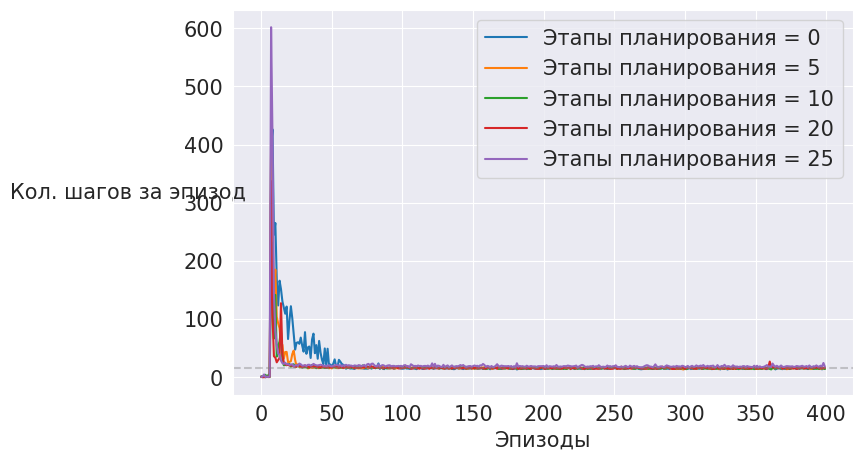

In [104]:
# Параметры эксперимента
experiment_parameters = {
    "num_runs" : 10,                     # Количество раз, когда мы проводим эксперимент
    "num_episodes" : 400,                 # Количество эпизодов в эксперименте
    "count_max_step": 3000,
}

# Параметры окружающей среды
environment_parameters = { 
    "discount": 0.95,
}

# Параметры агента
agent_parameters = {
    "num_states" : 81,
    "num_actions" : 4,
    "epsilon": 0.1,
    "step_size" : 0.125,
    "planning_steps" : [0, 5, 10, 20, 25]       # Список шагов планирования, которые мы хотим попробовать
}

current_env = MapEnvironment   # Окружающая среда
current_agent = Agent          # Агент

env_parmas = {
    'map_dim':[9, 9],
    'elements':
    {
        'wall':   [[6, 1], [6, 2], [6, 3], [6, 4], [6, 5], [6, 6], [6, 7]],
        'target': [[0, 8], ],
        'pit':    [[4, 5], [5, 5], [3, 5], [3, 4], [3, 3], [4, 3]],
    },
    'rewards':{ 'wall':-0.5, 'pit':-5, 'target':5 },
    'elements_color': { 'wall':'#364F6B', 'pit':'#FC5185', 'target':'#3FC1C9' },
    'start_state': [4, 4],
    'end_state':   [0, 8],
    'current_state':[None, None],
}

run_experiment(current_env, current_agent, env_parmas, environment_parameters, agent_parameters, experiment_parameters, show_map=False)
plot_steps_per_episode('results/Q_planning_steps.npy')
shutil.make_archive('results', 'zip', 'results');

Этапы планирования:  0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.64it/s]

Этапы планирования:  1



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.27it/s]

Этапы планирования:  2



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.17it/s]

Этапы планирования:  3



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.25it/s]

Этапы планирования:  4



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:10<00:00,  1.06s/it]


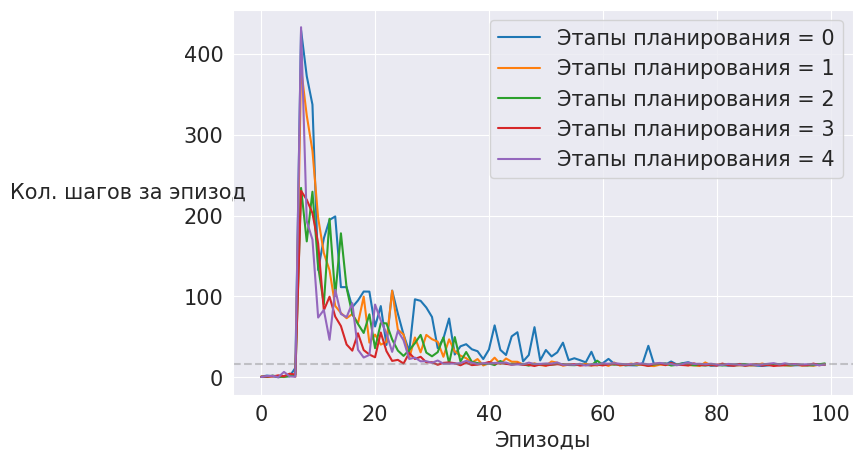

In [106]:
# Параметры эксперимента
experiment_parameters = {
    "num_runs" : 10,                     # Количество раз, когда мы проводим эксперимент
    "num_episodes" : 100,                 # Количество эпизодов в эксперименте
    "count_max_step": 3000,
}

# Параметры окружающей среды
environment_parameters = { 
    "discount": 0.95,
}

# Параметры агента
agent_parameters = {
    "num_states" : 81,
    "num_actions" : 4,
    "epsilon": 0.1,
    "step_size" : 0.125,
    "planning_steps" : [0, 1, 2, 3, 4]       # Список шагов планирования, которые мы хотим попробовать
}

current_env = MapEnvironment   # Окружающая среда
current_agent = Agent          # Агент

env_parmas = {
    'map_dim':[9, 9],
    'elements':
    {
        'wall':   [[6, 1], [6, 2], [6, 3], [6, 4], [6, 5], [6, 6], [6, 7]],
        'target': [[0, 8], ],
        'pit':    [[4, 5],[5, 5],[3, 5],[3, 4],[3, 3],[4, 3]],
    },
    'rewards':{ 'wall':-0.5, 'pit':-5, 'target':5 },
    'elements_color': { 'wall':'#364F6B', 'pit':'#FC5185', 'target':'#3FC1C9' },
    'start_state': [4, 4],
    'end_state':   [0, 8],
    'current_state':[None, None],
}

run_experiment(current_env, current_agent, env_parmas, environment_parameters, agent_parameters, experiment_parameters, show_map=False)
plot_steps_per_episode('results/Q_planning_steps.npy')
shutil.make_archive('results', 'zip', 'results');

Этапы планирования:  20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:33<00:00,  3.31s/it]

Этапы планирования:  25



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:32<00:00,  3.20s/it]


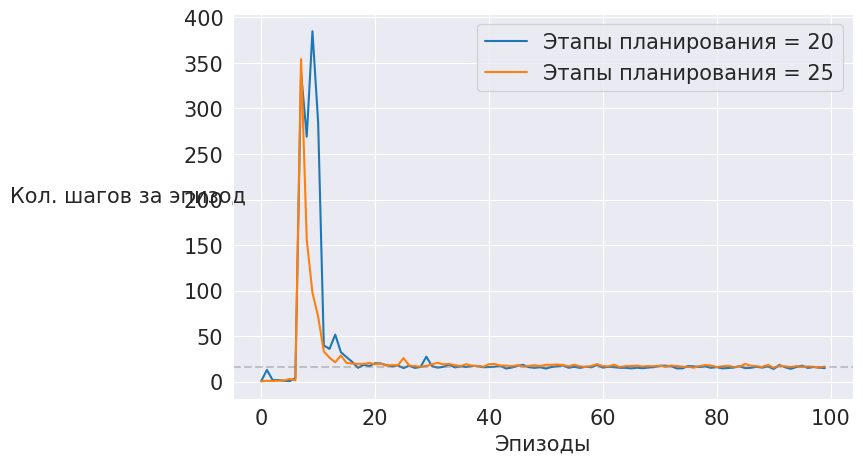

In [121]:
# Параметры эксперимента
experiment_parameters = {
    "num_runs" : 10,                     # Количество раз, когда мы проводим эксперимент
    "num_episodes" : 100,                 # Количество эпизодов в эксперименте
    "count_max_step": 3000,
}

# Параметры окружающей среды
environment_parameters = { 
    "discount": 0.95,
}

# Параметры агента
agent_parameters = {
    "num_states" : 81,
    "num_actions" : 4,
    "epsilon": 0.1,
    "step_size" : 0.125,
    "planning_steps" : [20, 25]       # Список шагов планирования, которые мы хотим попробовать
}

current_env = MapEnvironment   # Окружающая среда
current_agent = Agent          # Агент

env_parmas = {
    'map_dim':[9, 9],
    'elements':
    {
        'wall':   [[6, 1], [6, 2], [6, 3], [6, 4], [6, 5], [6, 6], [6, 7]],
        'target': [[0, 8], ],
        'pit':    [[4, 5], [5, 5], [3, 5], [3, 4], [3, 3], [4, 3]],
    },
    'rewards':{ 'wall':-0.5, 'pit':-5, 'target':5 },
    'elements_color': { 'wall':'#364F6B', 'pit':'#FC5185', 'target':'#3FC1C9' },
    'start_state': [4, 4],
    'end_state':   [0, 8],
    'current_state':[None, None],
}

run_experiment(current_env, current_agent, env_parmas, environment_parameters, agent_parameters, experiment_parameters, show_map=False)
plot_steps_per_episode('results/Q_planning_steps.npy')
shutil.make_archive('results', 'zip', 'results');

Этапы планирования:  5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.04it/s]

Этапы планирования:  10



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:15<00:00,  1.60s/it]


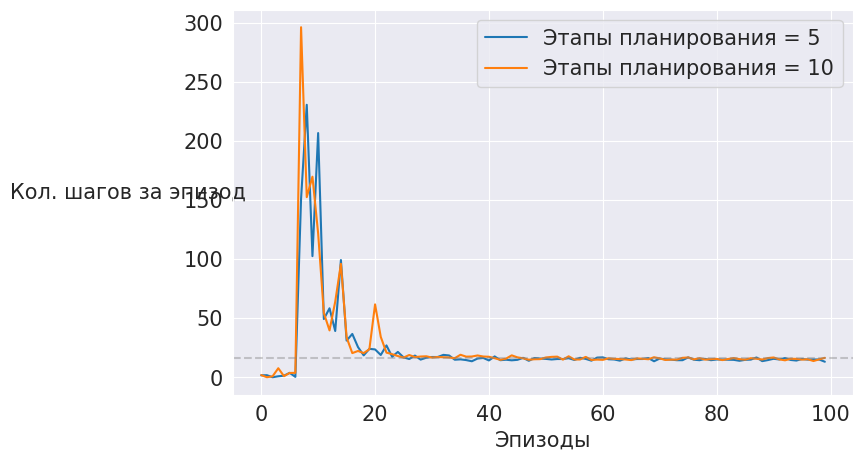

In [123]:
# Параметры эксперимента
experiment_parameters = {
    "num_runs" : 10,                     # Количество раз, когда мы проводим эксперимент
    "num_episodes" : 100,                 # Количество эпизодов в эксперименте
    "count_max_step": 3000,
}

# Параметры окружающей среды
environment_parameters = {
    "discount": 0.95,
}

# Параметры агента
agent_parameters = {
    "num_states" : 81,
    "num_actions" : 4,
    "epsilon": 0.1,
    "step_size" : 0.125,
    "planning_steps" : [5, 10]       # Список шагов планирования, которые мы хотим попробовать
}

current_env = MapEnvironment   # Окружающая среда
current_agent = Agent          # Агент

env_parmas = {
    'map_dim':[9, 9],
    'elements':
    {
        'wall':   [[6, 1], [6, 2], [6, 3], [6, 4], [6, 5], [6, 6], [6, 7]],
        'target': [[0, 8], ],
        'pit':    [[4, 5], [5, 5], [3, 5], [3, 4], [3, 3], [4, 3]],
    },
    'rewards':{ 'wall':-0.5, 'pit':-5, 'target':5 },
    'elements_color': { 'wall':'#364F6B', 'pit':'#FC5185', 'target':'#3FC1C9' },
    'start_state': [4, 4],
    'end_state':   [0, 8],
    'current_state':[None, None],
}

run_experiment(current_env, current_agent, env_parmas, environment_parameters, agent_parameters, experiment_parameters, show_map=False)
plot_steps_per_episode('results/Q_planning_steps.npy')
shutil.make_archive('results', 'zip', 'results');

Этапы планирования:  20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:59<00:00, 11.92s/it]

Этапы планирования:  25



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:16<00:00, 13.68s/it]


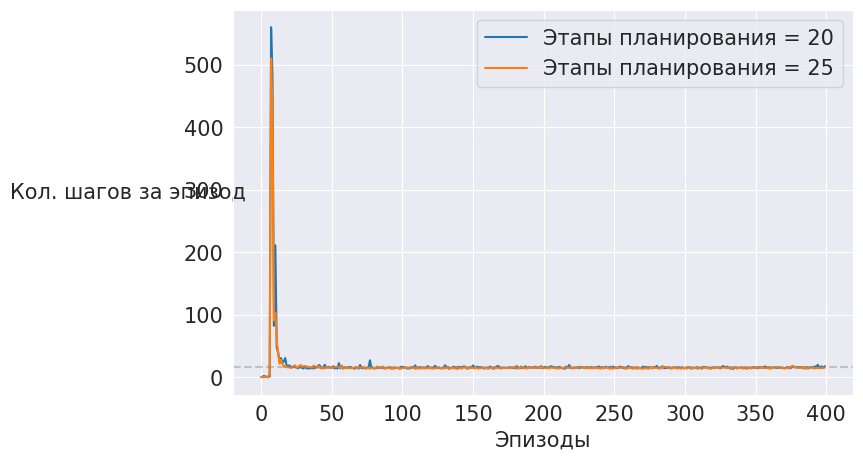

In [18]:
# Параметры эксперимента
experiment_parameters = {
    "num_runs" : 10,                     # Количество раз, когда мы проводим эксперимент
    "num_episodes" : 400,                 # Количество эпизодов в эксперименте
    "count_max_step": 3000,
}

# Параметры окружающей среды
environment_parameters = { 
    "discount": 0.95,
}

# Параметры агента
agent_parameters = {
    "num_states" : 81,
    "num_actions" : 4,
    "epsilon": 0.1,
    "step_size" : 0.125,
    "planning_steps" : [20, 25]       # Список шагов планирования, которые мы хотим попробовать
}

current_env = MapEnvironment   # Окружающая среда
current_agent = Agent          # Агент

env_parmas = {
    'map_dim':[9, 9],
    'elements':
    {
        'wall':   [[6, 1], [6, 2], [6, 3], [6, 4], [6, 5], [6, 6], [6, 7]],
        'target': [[0, 8], ],
        'pit':    [[4, 5], [5, 5], [3, 5], [3, 4], [3, 3], [4, 3]],
    },
    'rewards':{ 'wall':-0.5, 'pit':-5, 'target':5 },
    'elements_color': { 'wall':'#364F6B', 'pit':'#FC5185', 'target':'#3FC1C9' },
    'start_state': [4, 4],
    'end_state':   [0, 8],
    'current_state':[None, None],
}

run_experiment(current_env, current_agent, env_parmas, environment_parameters, agent_parameters, experiment_parameters, show_map=False)
plot_steps_per_episode('results/Q_planning_steps.npy')
shutil.make_archive('results', 'zip', 'results');

Этапы планирования:  10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:23<00:00,  2.30s/it]


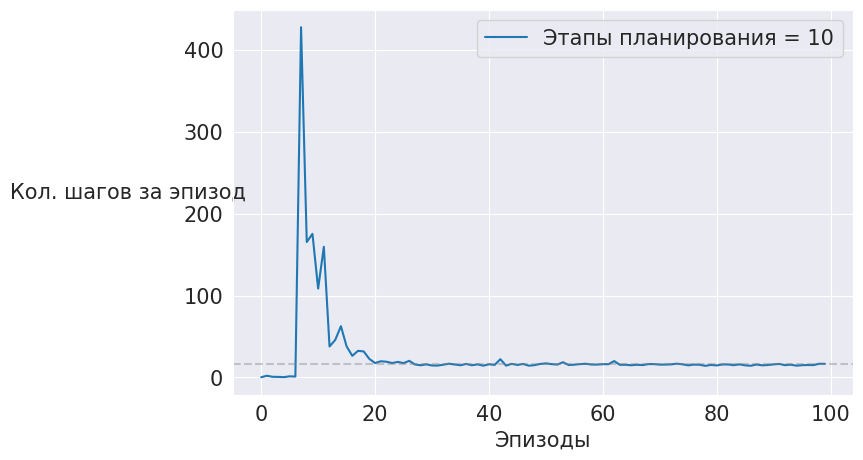

In [19]:
# Параметры эксперимента
experiment_parameters = {
    "num_runs" : 10,                     # Количество раз, когда мы проводим эксперимент
    "num_episodes" : 100,                 # Количество эпизодов в эксперименте
    "count_max_step": 3000,
}

# Параметры окружающей среды
environment_parameters = { 
    "discount": 0.95,
}

# Параметры агента
agent_parameters = {
    "num_states" : 81,
    "num_actions" : 4,
    "epsilon": 0.1,
    "step_size" : 0.125,
    "planning_steps" : [10]       # Список шагов планирования, которые мы хотим попробовать
}

current_env = MapEnvironment   # Окружающая среда
current_agent = Agent          # Агент

env_parmas = {
    'map_dim':[9, 9],
    'elements':
    {
        'wall':   [[6, 1], [6, 2], [6, 3], [6, 4], [6, 5], [6, 6], [6, 7]],
        'target': [[0, 8], ],
        'pit':    [[4, 5], [5, 5], [3, 5], [3, 4], [3, 3], [4, 3]],
    },
    'rewards':{ 'wall':-0.5, 'pit':-5, 'target':5 },
    'elements_color': { 'wall':'#364F6B', 'pit':'#FC5185', 'target':'#3FC1C9' },
    'start_state': [4, 4],
    'end_state':   [0, 8],
    'current_state':[None, None],
}

run_experiment(current_env, current_agent, env_parmas, environment_parameters, agent_parameters, experiment_parameters, show_map=False)
plot_steps_per_episode('results/Q_planning_steps.npy')
shutil.make_archive('results', 'zip', 'results');

In [ ]:
# Параметры эксперимента
experiment_parameters = {
    "num_runs" : 10,                     # Количество раз, когда мы проводим эксперимент
    "num_episodes" : 400,                 # Количество эпизодов в эксперименте
    "count_max_step": 3000,
}

# Параметры окружающей среды
environment_parameters = { 
    "discount": 0.95,
}

# Параметры агента
agent_parameters = {
    "num_states" : 81,
    "num_actions" : 4,
    "epsilon": 0.1,
    "step_size" : 0.125,
    "planning_steps" : [25, 20]       # Список шагов планирования, которые мы хотим попробовать
}

current_env = MapEnvironment   # Окружающая среда
current_agent = Agent          # Агент

env_parmas = {
    'map_dim':[9, 9],
    'elements':
    {
        'wall':   [[6, 1], [6, 2], [6, 3], [6, 4], [6, 5], [6, 6], [6, 7]],
        'target': [[0, 8], ],
        'pit':    [[4, 5], [5, 5], [3, 5], [3, 4], [3, 3], [4, 3]],
    },
    'rewards':{ 'wall':-0.5, 'pit':-5, 'target':5 },
    'elements_color': { 'wall':'#364F6B', 'pit':'#FC5185', 'target':'#3FC1C9' },
    'start_state': [4, 4],
    'end_state':   [0, 8],
    'current_state':[None, None],
}

run_experiment(current_env, current_agent, env_parmas, environment_parameters, agent_parameters, experiment_parameters, show_map=False)
plot_steps_per_episode('results/Q_planning_steps.npy')
shutil.make_archive('results', 'zip', 'results');

In [ ]:
# Параметры эксперимента
experiment_parameters = {
    "num_runs" : 10,                     # Количество раз, когда мы проводим эксперимент
    "num_episodes" : 400,                 # Количество эпизодов в эксперименте
    "count_max_step": 3000,
}

# Параметры окружающей среды
environment_parameters = { 
    "discount": 0.95,
}

# Параметры агента
agent_parameters = {
    "num_states" : 81,
    "num_actions" : 4,
    "epsilon": 0.1,
    "step_size" : 0.125,
    "planning_steps" : [10, 20, 25]       # Список шагов планирования, которые мы хотим попробовать
}

current_env = MapEnvironment   # Окружающая среда
current_agent = Agent          # Агент

env_parmas = {
    'map_dim':[9, 9],
    'elements':
    {
        'wall':   [[6, 1], [6, 2], [6, 3], [6, 4], [6, 5], [6, 6], [6, 7]],
        'target': [[0, 8], ],
        'pit':    [[4, 5], [5, 5], [3, 5], [3, 4], [3, 3], [4, 3]],
    },
    'rewards':{ 'wall':-0.5, 'pit':-5, 'target':5 },
    'elements_color': { 'wall':'#364F6B', 'pit':'#FC5185', 'target':'#3FC1C9' },
    'start_state': [4, 4],
    'end_state':   [0, 8],
    'current_state':[None, None],
}

run_experiment(current_env, current_agent, env_parmas, environment_parameters, agent_parameters, experiment_parameters, show_map=False)
plot_steps_per_episode('results/Q_planning_steps.npy')
shutil.make_archive('results', 'zip', 'results');

Этапы планирования:  10


  0%|          | 0/10 [00:00<?, ?it/s]

Этапы планирования:  0


100%|##########| 10/10 [00:08<00:00,  1.13it/s]


Этапы планирования:  1


100%|##########| 10/10 [00:14<00:00,  1.41s/it]


Этапы планирования:  2


100%|##########| 10/10 [00:19<00:00,  1.98s/it]


Этапы планирования:  3


100%|##########| 10/10 [00:23<00:00,  2.40s/it]


Этапы планирования:  4


100%|##########| 10/10 [00:25<00:00,  2.52s/it]


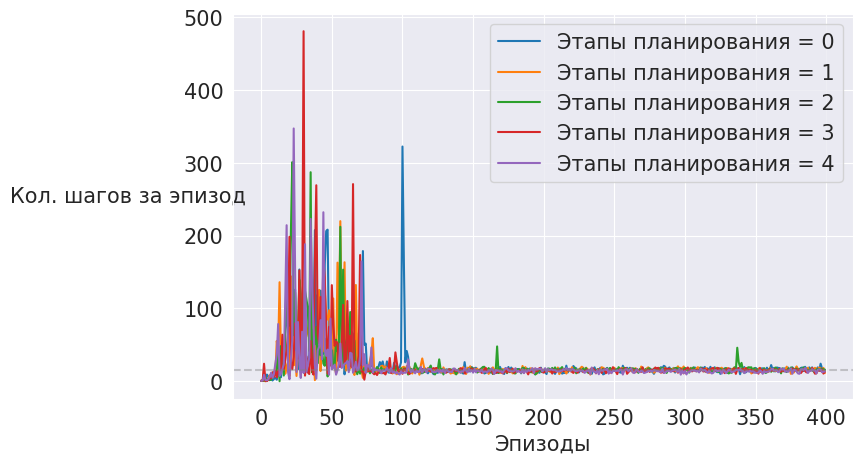

In [22]:
# Параметры эксперимента
experiment_parameters = {
    "num_runs" : 10,                     # Количество раз, когда мы проводим эксперимент
    "num_episodes" : 400,                 # Количество эпизодов в эксперименте
    "count_max_step": 3000,
}

# Параметры окружающей среды
environment_parameters = { 
    "discount": 0.95,
}

# Параметры агента
agent_parameters = {
    "num_states" : 81,
    "num_actions" : 4,
    "epsilon": 0.1,
    "step_size" : 0.125,
    "planning_steps" : [0, 1, 2, 3, 4]       # Список шагов планирования, которые мы хотим попробовать
}

current_env = MapEnvironment   # Окружающая среда
current_agent = Agent          # Агент

env_parmas = {
    'map_dim':[9, 9],
    'elements':
    {
        'wall':   [[6, 1], [6, 2], [6, 3], [6, 4], [6, 5], [6, 6], [6, 7]],
        'target': [[0, 8], ],
        'pit':    [[4, 5],[5, 5],[3, 5],[3, 4],[3, 3],[4, 3]],
    },
    'rewards':{ 'wall':-0.5, 'pit':-5, 'target':5 },
    'elements_color': { 'wall':'#364F6B', 'pit':'#FC5185', 'target':'#3FC1C9' },
    'start_state': [4, 4],
    'end_state':   [0, 8],
    'current_state':[None, None],
}

run_experiment(current_env, current_agent, env_parmas, environment_parameters, agent_parameters, experiment_parameters, show_map=False)
plot_steps_per_episode('results/Q_planning_steps.npy')
shutil.make_archive('results', 'zip', 'results');

Этапы планирования:  0


100%|##########| 10/10 [00:09<00:00,  1.04it/s]


Этапы планирования:  5


100%|##########| 10/10 [00:25<00:00,  2.55s/it]


Этапы планирования:  10


100%|##########| 10/10 [00:40<00:00,  4.02s/it]


Этапы планирования:  20


100%|##########| 10/10 [01:03<00:00,  6.33s/it]


Этапы планирования:  25


100%|##########| 10/10 [01:16<00:00,  7.65s/it]


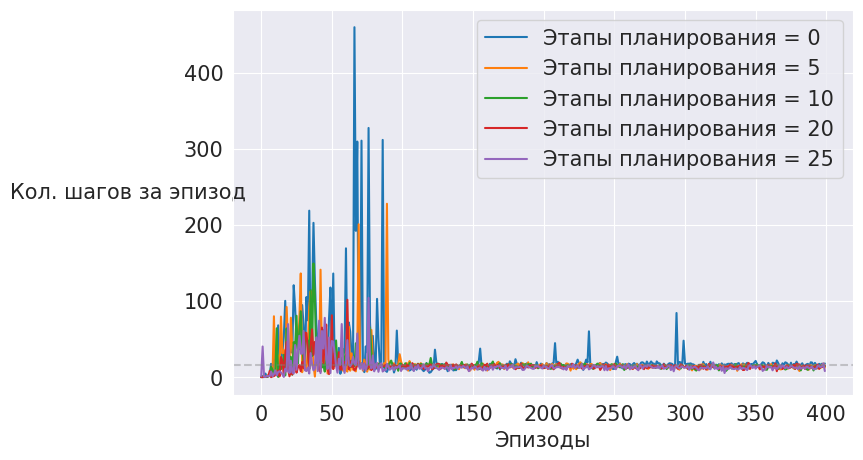

In [23]:
# Параметры эксперимента
experiment_parameters = {
    "num_runs" : 10,                     # Количество раз, когда мы проводим эксперимент
    "num_episodes" : 400,                 # Количество эпизодов в эксперименте
    "count_max_step": 3000,
}

# Параметры окружающей среды
environment_parameters = { 
    "discount": 0.95,
}

# Параметры агента
agent_parameters = {
    "num_states" : 81,
    "num_actions" : 4,
    "epsilon": 0.1,
    "step_size" : 0.125,
    "planning_steps" : [0, 5, 10, 20, 25]       # Список шагов планирования, которые мы хотим попробовать
}

current_env = MapEnvironment   # Окружающая среда
current_agent = Agent          # Агент

env_parmas = {
    'map_dim':[9, 9],
    'elements':
    {
        'wall':   [[6, 1], [6, 2], [6, 3], [6, 4], [6, 5], [6, 6], [6, 7]],
        'target': [[0, 8],],
        'pit':    [[4, 5], [5, 5], [3, 5], [3, 4], [3, 3], [4, 3]],
    },
    'rewards':{ 'wall':-0.5, 'pit':-5, 'target':5 },
    'elements_color': { 'wall':'#364F6B', 'pit':'#FC5185', 'target':'#3FC1C9' },
    'start_state': [4, 4],
    'end_state':   [0, 8],
    'current_state':[None, None],
}

run_experiment(current_env, current_agent, env_parmas, environment_parameters, agent_parameters, experiment_parameters, show_map=False)
plot_steps_per_episode('results/Q_planning_steps.npy')
shutil.make_archive('results', 'zip', 'results');

### Отображение и запись поведения агента на карте состояний

In [ ]:
# Параметры эксперимента
experiment_parameters = {
    "num_runs" : 1,                     # Количество раз, когда мы проводим эксперимент
    "num_episodes" : 100,                 # Количество эпизодов в эксперименте
    "count_max_step" : 4000,
}

# Параметры окружающей среды
environment_parameters = { 
    "discount": 0.95,
}

# Параметры агента
agent_parameters = {
    "num_states" : 81,
    "num_actions" : 4,
    "epsilon": 0.1,
    "step_size" : 0.125,
    "planning_steps" : [5],       # Список шагов планирования, которые мы хотим попробовать
}

current_env = MapEnvironment   # Окружающая среда
current_agent = Agent          # Агент

env_parmas = {
    'map_dim':[9, 9],
    'elements':
    {
        'wall':   [[6, 1], [6, 2], [6, 3], [6, 4], [6, 5], [6, 6], [6, 7]],
        'target': [[0, 8],],
        'pit':    [[4, 5], [5, 5], [3, 5], [3, 4], [3, 3], [4, 3]],
    },
    'rewards':{ 'wall':-0.5, 'pit':-5, 'target':5 },
    'elements_color': { 'wall':'#364F6B', 'pit':'#FC5185', 'target':'#3FC1C9' },
    'start_state': [4, 4],
    'end_state':   [0, 8],
    'current_state':[None, None],
}

run_experiment(current_env, current_agent, env_parmas, environment_parameters, agent_parameters, experiment_parameters, show_map=True)
plot_steps_per_episode('results/Q_planning_steps.npy')
shutil.make_archive('results', 'zip', 'results');